In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.4 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def evaluate_policy(policy, environment, gamma=0.9, tolerance=1e-6):
    value_function = np.zeros(environment.observation_space.n)
    while True:
        delta = 0
        for state in range(environment.observation_space.n):
            value = 0
            for action, action_prob in enumerate(policy[state]):
                for prob, next_state, reward, done in environment.P[state][action]:
                    value += action_prob * prob * (reward + gamma * value_function[next_state])
            delta = max(delta, abs(value - value_function[state]))
            value_function[state] = value
        if delta < tolerance:
            break
    return value_function


In [4]:
def improve_policy(environment, evaluate_policy_fn=evaluate_policy, gamma=0.9):
    policy = np.ones([environment.observation_space.n, environment.action_space.n]) / environment.action_space.n
    while True:
        value_function = evaluate_policy_fn(policy, environment, gamma)
        policy_stable = True
        for state in range(environment.observation_space.n):
            current_action = np.argmax(policy[state])
            action_values = np.zeros(environment.action_space.n)
            for action in range(environment.action_space.n):
                for prob, next_state, reward, done in environment.P[state][action]:
                    action_values[action] += prob * (reward + gamma * value_function[next_state])
            best_action = np.argmax(action_values)
            if current_action != best_action:
                policy_stable = False
            policy[state] = np.eye(environment.action_space.n)[best_action]
        if policy_stable:
            return policy, value_function



In [5]:
def execute_episodes(num_episodes, visualize=False):
    environment = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode='human' if visualize else None)

    optimal_policy, optimal_value_function = improve_policy(environment)

    episode_rewards = np.zeros(num_episodes)

    for episode in range(num_episodes):
        state = environment.reset()[0]
        game_finished = False
        timeout_occurred = False

        while not game_finished and not timeout_occurred:
            action = np.argmax(optimal_policy[state])
            next_state, reward, game_finished, timeout_occurred, _ = environment.step(action)
            state = next_state

        episode_rewards[episode] = reward

    environment.close()

    reward_sum = np.zeros(num_episodes)
    for i in range(num_episodes):
        reward_sum[i] = np.sum(episode_rewards[max(0, i - 100):(i + 1)])
    plt.plot(reward_sum)
    plt.savefig('frozen_lake_policy_iteration.png')

    with open("frozen_lake_policy_iteration_policy.pkl", "wb") as file:
        pickle.dump(optimal_policy, file)

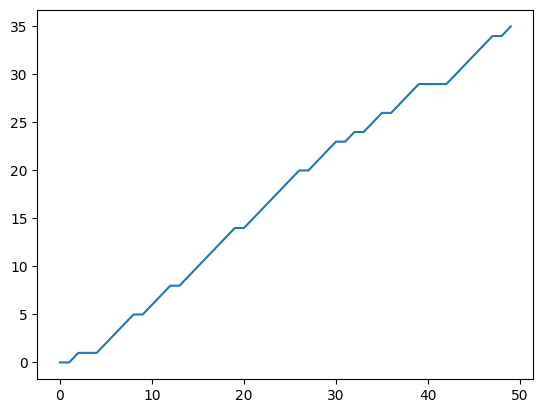

In [7]:
execute_episodes(1500, visualize=True)